# Mejorar la predicción de un modelo lineal con NN

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests 
session = tf.Session()

In [3]:
url = "https://raw.githubusercontent.com/joanby/tensorflow/master/datasets/birthweight.dat?token=AMRAeLOMrOCZKT3UgcdcA3VC4ep-4pYNks5cb-CGwA%3D%3D"
birth_file = requests.get(url)
birth_data = birth_file.text.split('\r\n')
birth_header = birth_data[0].split('\t')
birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]

In [4]:
y_vals = np.array([x[0] for x in birth_data])
x_vals = np.array([x[1:8] for x in birth_data])

In [5]:
seed = 2019
tf.set_random_seed(seed)
np.random.seed(seed)
batch_size = 80

In [6]:
train_idx = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_idx = np.array(list(set(range(len(x_vals)))-set(train_idx)))

In [7]:
x_vals_train = x_vals[train_idx]
x_vals_test = x_vals[test_idx]
y_vals_train = y_vals[train_idx]
y_vals_test = y_vals[test_idx]

In [8]:
def normalize_cols(m, col_min = np.array([None]), col_max = np.array([None])):
    if not col_min[0]:
        col_min = m.min(axis=0)
    if not col_max[0]:
        col_max = m.max(axis=0)
    return(m-col_min)/(col_max-col_min), col_min, col_max

In [9]:
x_vals_train, train_min, train_max = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test,_,_ = np.nan_to_num(normalize_cols(x_vals_test, train_min, train_max))

In [10]:
x_data = tf.placeholder(shape=[None, 7],dtype = tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [11]:
def init_variables(shape):
    return tf.Variable(tf.random_normal(shape=shape))

In [12]:
def logistic(input_layer, multiplication_weight, bias_weight, activation_sig = True):
    linear_layer = tf.add(tf.matmul(input_layer, multiplication_weight), bias_weight)
    if activation_sig:
        return tf.nn.sigmoid(linear_layer)
    else:
        return linear_layer

- Entrada: 7 datos -> Capa oculta 1: 14 nodos ocultos
- Capa oculta 1: 14 nodos -> Capa oculta 2: 5 nodos ocultos
- Capa oculta 2: 5 nodos -> Capa salida -> 1 nodo

In [15]:
A1 = init_variables(shape=[7,14])
b1 = init_variables(shape=[14])
logistic_layer_1 = logistic(x_data,A1,b1)

A2 = init_variables(shape=[14,5])
b2 = init_variables(shape=[5])
logistic_layer_2 = logistic(logistic_layer_1,A2,b2)

A3 = init_variables(shape=[5,1])
b3 = init_variables(shape=[1])
final_output = logistic(logistic_layer_2,A3,b3, activation_sig=False)

In [16]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=final_output, labels=y_target))

In [17]:
my_optim = tf.train.AdamOptimizer(learning_rate=0.002)
train_step = my_optim.minimize(loss)

In [18]:
init = tf.global_variables_initializer()
session.run(init)

In [19]:
prediction = tf.round(tf.nn.sigmoid(final_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [20]:
loss_vect = []
train_acc = []
test_acc = []

for i in range(1500):
    rand_idx = np.random.choice(len(x_vals_train), size = batch_size)
    rand_x = x_vals_train[rand_idx]
    rand_y = np.transpose([y_vals_train[rand_idx]])
    
    session.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = session.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vect.append(temp_loss)
    
    temp_acc_train = session.run(accuracy, feed_dict={x_data: x_vals_train, y_target: np.transpose([y_vals_train])})
    train_acc.append(temp_acc_train)
    
    temp_acc_test = session.run(accuracy, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_acc.append(temp_acc_test)
    
    if(i+1)%100==0:
        print("Paso #"+str(i+1)+", Loss = "+str(temp_loss)+", Precisión = "+str(temp_acc_train))

Paso #100, Loss = 0.70932484, Precisión = 0.68874174
Paso #200, Loss = 0.56022644, Precisión = 0.68874174
Paso #300, Loss = 0.6868788, Precisión = 0.68874174
Paso #400, Loss = 0.4967518, Precisión = 0.7152318
Paso #500, Loss = 0.48636776, Precisión = 0.74172187
Paso #600, Loss = 0.5120451, Precisión = 0.7549669
Paso #700, Loss = 0.4664154, Precisión = 0.77483445
Paso #800, Loss = 0.46698713, Precisión = 0.77483445
Paso #900, Loss = 0.49174112, Precisión = 0.77483445
Paso #1000, Loss = 0.5104518, Precisión = 0.77483445
Paso #1100, Loss = 0.42984733, Precisión = 0.78145695
Paso #1200, Loss = 0.5103024, Precisión = 0.77483445
Paso #1300, Loss = 0.4600067, Precisión = 0.78145695
Paso #1400, Loss = 0.47587055, Precisión = 0.78145695
Paso #1500, Loss = 0.5097362, Precisión = 0.78145695


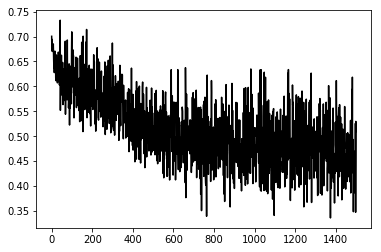

In [22]:
plt.plot(loss_vect, 'k-')
plt.show()

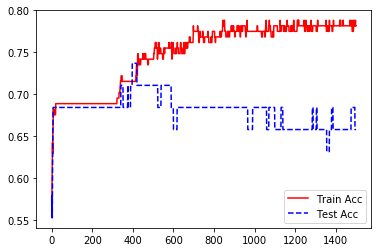

In [24]:
plt.plot(train_acc, 'r-', label="Train Acc")
plt.plot(test_acc, 'b--', label="Test Acc")
plt.legend(loc="lower right")
plt.show()